In [6]:
import cv2
from matplotlib import pyplot as plt
import math
import numpy as np

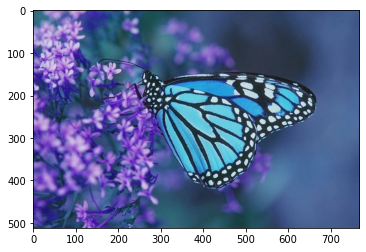

In [40]:
## if __name__ == “main”
# PATCH - SIZE : 7*7
# Declaring parameters for the retargeting
minImgSize = 30;                # lowest scale resolution size for min(w, h)
numScales = 10;                 # number of scales (distributed logarithmically)


## Preparing data for the retargeting
pathname = 'img/ours_9_aaa.jpg'
dx, dy = 1, 0.6
org_image = cv2.imread(pathname)
ref_image = cv2.imread("img/ours_10_aaa.jpg")
plt.imshow(ref_image)
h, w, _ = org_image.shape
resized_image = cv2.resize(org_image, None, fx = dx, fy = dy)

47 12


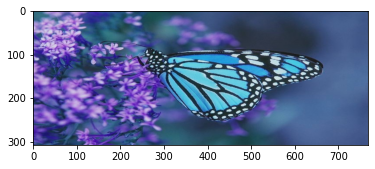

In [8]:
plt.imshow(resized_image)
image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2LAB)

## retargeting at havlved images
'''
target_w= 30;

down_w = 47;
down_h = math.ceil(dy * h * target_w / (dx * w))

down_source = (np.zeros([down_h, down_w, 3])).astype(np.uint8)
print(down_w, down_h)
for i in range(down_h):
    for j in range(down_w):
        down_R = math.ceil(i * h / down_h)
        down_C = math.ceil(j * w / down_w)
        down_source[i][j][:] = org_image[down_R][down_C][:]

#plt.imshow(down_source)
'''

In [16]:
import numpy as np
from PIL import Image
import time
from tqdm.notebook import tqdm

def cal_distance(a, b, A_padding, B, p_size):
    p = p_size // 2
    patch_a = A_padding[a[0]:a[0]+p_size, a[1]:a[1]+p_size, :]
    patch_b = B[b[0]-p:b[0]+p+1, b[1]-p:b[1]+p+1, :]
    temp = patch_b - patch_a
    num = np.sum(1 - np.int32(np.isnan(temp)))
    dist = np.sum(np.square(np.nan_to_num(temp))) / num
    return dist

def reconstruction(f, A, B):
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    temp = np.zeros_like(A)
    for i in tqdm(range(A_h)):
        for j in range(A_w):
            temp[i, j, :] = B[f[i, j][0], f[i, j][1], :]
    Image.fromarray(temp).show()


def initialization(A, B, p_size):
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    B_h = np.size(B, 0)
    B_w = np.size(B, 1)
    p = p_size // 2
    random_B_r = np.random.randint(p, B_h-p, [A_h, A_w])
    random_B_c = np.random.randint(p, B_w-p, [A_h, A_w])
    A_padding = np.ones([A_h+p*2, A_w+p*2, 3]) * np.nan
    A_padding[p:A_h+p, p:A_w+p, :] = A
    f = np.zeros([A_h, A_w], dtype=object)
    dist = np.zeros([A_h, A_w])
    for i in range(A_h):
        for j in range(A_w):
            a = np.array([i, j])
            b = np.array([random_B_r[i, j], random_B_c[i, j]], dtype=np.int32)
            f[i, j] = b
            dist[i, j] = cal_distance(a, b, A_padding, B, p_size)
    return f, dist, A_padding

def propagation(f, a, dist, A_padding, B, p_size, is_odd):
    A_h = np.size(A_padding, 0) - p_size + 1
    A_w = np.size(A_padding, 1) - p_size + 1
    x = a[0]
    y = a[1]
    if is_odd:
        d_left = dist[max(x-1, 0), y]
        d_up = dist[x, max(y-1, 0)]
        d_current = dist[x, y]
        idx = np.argmin(np.array([d_current, d_left, d_up]))
        if idx == 1:
            f[x, y] = f[max(x - 1, 0), y]
            dist[x, y] = cal_distance(a, f[x, y], A_padding, B, p_size)
        if idx == 2:
            f[x, y] = f[x, max(y - 1, 0)]
            dist[x, y] = cal_distance(a, f[x, y], A_padding, B, p_size)
    else:
        d_right = dist[min(x + 1, A_h-1), y]
        d_down = dist[x, min(y + 1, A_w-1)]
        d_current = dist[x, y]
        idx = np.argmin(np.array([d_current, d_right, d_down]))
        if idx == 1:
            f[x, y] = f[min(x + 1, A_h-1), y]
            dist[x, y] = cal_distance(a, f[x, y], A_padding, B, p_size)
        if idx == 2:
            f[x, y] = f[x, min(y + 1, A_w-1)]
            dist[x, y] = cal_distance(a, f[x, y], A_padding, B, p_size)

def random_search(f, a, dist, A_padding, B, p_size, alpha=0.5):
    x = a[0]
    y = a[1]
    B_h = np.size(B, 0)
    B_w = np.size(B, 1)
    p = p_size // 2
    i = 4
    search_h = B_h * alpha ** i
    search_w = B_w * alpha ** i
    b_x = f[x, y][0]
    b_y = f[x, y][1]
    while search_h > 1 and search_w > 1:
        search_min_r = max(b_x - search_h, p)
        search_max_r = min(b_x + search_h, B_h-p)
        random_b_x = np.random.randint(search_min_r, search_max_r)
        search_min_c = max(b_y - search_w, p)
        search_max_c = min(b_y + search_w, B_w - p)
        random_b_y = np.random.randint(search_min_c, search_max_c)
        search_h = B_h * alpha ** i
        search_w = B_w * alpha ** i
        b = np.array([random_b_x, random_b_y])
        d = cal_distance(a, b, A_padding, B, p_size)
        if d < dist[x, y]:
            dist[x, y] = d
            f[x, y] = b
        i += 1

def NNS(img, ref, p_size, itr):
    A_h = np.size(img, 0)
    A_w = np.size(img, 1)
    f, dist, img_padding = initialization(img, ref, p_size)
    for itr in range(1, itr+1):
        print("iter:", itr)
        if itr % 2 == 0:
            for i in tqdm(range(A_h - 1, -1, -1)):
                for j in range(A_w - 1, -1, -1):
                    a = np.array([i, j])
                    propagation(f, a, dist, img_padding, ref, p_size, False)
                    random_search(f, a, dist, img_padding, ref, p_size)
        else:
            for i in tqdm(range(A_h)):
                for j in range(A_w):
                    a = np.array([i, j])
                    propagation(f, a, dist, img_padding, ref, p_size, True)
                    random_search(f, a, dist, img_padding, ref, p_size)
        print("iteration: %d"%(itr))
    return f



iter: 1


  0%|          | 0/512 [00:00<?, ?it/s]

iteration: 1
iter: 2


  0%|          | 0/512 [00:00<?, ?it/s]

iteration: 2
454.08896112442017


  0%|          | 0/512 [00:00<?, ?it/s]

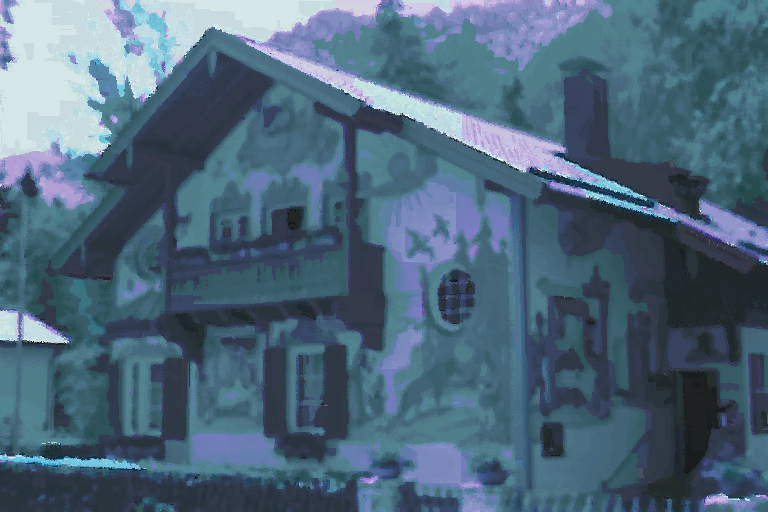

In [37]:
if __name__ == "__main__":
    #img = np.array(Image.open("./cup_a.jpg"))
    #ref = np.array(Image.open("./cup_b.jpg"))
    p_size = 7
    itr = 2
    start = time.time()
    f = NNS(ref_image, org_image, p_size, itr)
    end = time.time()
    print(end - start)
    # new = np.zeros(resized_image.shape)
    reconstruction(f, ref_image, org_image)

In [42]:
import numpy as np
import scipy.misc as misc
from PIL import Image
import cv2
import time

def normalize(F_L):
    return F_L/np.sqrt(np.sum(np.square(F_L)))

def cal_distance(A, B, A_prime, B_prime, a_x, a_y, b_x, b_y, patch_size):
    A_H = A.shape[0]
    A_W = A.shape[1]
    B_H = B.shape[0]
    B_W = B.shape[1]
    dx0 = dy0 = patch_size // 2
    dx1 = dy1 = patch_size // 2 + 1
    dx0 = min(a_x, b_x, dx0)
    dx1 = min(A_H - a_x, B_H - b_x, dx1)
    dy0 = min(a_y, b_y, dy0)
    dy1 = min(A_W - a_y, B_W - b_y, dy1)
    patch_A = A[a_x - dx0:a_x + dx1, a_y - dy0:a_y + dy1]
    patch_A_prime = A_prime[a_x - dx0:a_x + dx1, a_y - dy0:a_y + dy1]
    patch_B = B[b_x - dx0:b_x + dx1, b_y - dy0:b_y + dy1]
    patch_B_prime = B_prime[b_x - dx0:b_x + dx1, b_y - dy0:b_y + dy1]
    dist = (np.sum((patch_A - patch_B) ** 2 + (patch_A_prime - patch_B_prime) ** 2)) / ((dx0 + dx1) * (dy0 + dy1))
    return dist

def init_nnf(A, B):
    A_H = A.shape[0]
    A_W = A.shape[1]
    nnf = np.zeros([A_H, A_W, 2], dtype=np.int32)
    nnf[:, :, 0] = np.random.randint(0, B.shape[0], size=[A_H, A_W])
    nnf[:, :, 1] = np.random.randint(0, B.shape[1], size=[A_H, A_W])
    return nnf

def init_nnd(A, B, A_prime, B_prime, SHAPE, nnf, patch_size):
    A_H = SHAPE[0]
    A_W = SHAPE[1]
    dist = np.zeros([A_H, A_W])
    for i in range(A_H):
        for j in range(A_W):
            dist[i, j] = cal_distance(A, B, A_prime, B_prime, i, j, nnf[i, j, 0], nnf[i, j, 1], patch_size)
    return dist

def propagation(A, B, A_prime, B_prime, SHAPE, a_x, a_y, nnf, nnd, patch_size, is_odd):
    A_H = SHAPE[0]
    A_W = SHAPE[1]
    B_H = SHAPE[2]
    B_W = SHAPE[3]
    if is_odd:
        d_best = nnd[a_x, a_y]
        best_b_x = nnf[a_x, a_y, 0]
        best_b_y = nnf[a_x, a_y, 1]
        if a_y - 1 >= 0:
            b_x = nnf[a_x, a_y - 1, 0]
            b_y = nnf[a_x, a_y - 1, 1] + 1
            if b_y < B_W:
                dist = cal_distance(A, B, A_prime, B_prime, a_x, a_y, b_x, b_y, patch_size)
                if dist < d_best:
                    best_b_x, best_b_y, d_best = b_x, b_y, dist
        if a_x - 1 >= 0:
            b_x = nnf[a_x - 1, a_y, 0] + 1
            b_y = nnf[a_x - 1, a_y, 1]
            if b_x < B_H:
                dist = cal_distance(A, B, A_prime, B_prime, a_x, a_y, b_x, b_y, patch_size)
                if dist < d_best:
                    best_b_x, best_b_y, d_best = b_x, b_y, dist
        nnf[a_x, a_y] = [best_b_x, best_b_y]
        nnd[a_x, a_y] = d_best
    else:
        d_best = nnd[a_x, a_y]
        best_b_x = nnf[a_x, a_y, 0]
        best_b_y = nnf[a_x, a_y, 1]
        if a_y + 1 < A_W:
            b_x = nnf[a_x, a_y + 1, 0]
            b_y = nnf[a_x, a_y + 1, 1] - 1
            if b_y >= 0:
                dist = cal_distance(A, B, A_prime, B_prime, a_x, a_y, b_x, b_y, patch_size)
                if dist < d_best:
                    best_b_x, best_b_y, d_best = b_x, b_y, dist
        if a_x + 1 < A_H:
            b_x = nnf[a_x + 1, a_y, 0] - 1
            b_y = nnf[a_x + 1, a_y, 1]
            if b_x >= 0:
                dist = cal_distance(A, B, A_prime, B_prime, a_x, a_y, b_x, b_y, patch_size)
                if dist < d_best:
                    best_b_x, best_b_y, d_best = b_x, b_y, dist
        nnf[a_x, a_y] = [best_b_x, best_b_y]
        nnd[a_x, a_y] = d_best

    return nnf, nnd

def random_search(A, B, A_prime, B_prime, SHAPE, a_x, a_y, nnf, nnd, search_radius, patch_size):
    B_H = SHAPE[2]
    B_W = SHAPE[3]
    best_b_x = nnf[a_x, a_y, 0]
    best_b_y = nnf[a_x, a_y, 1]
    best_dist = nnd[a_x, a_y]
    while search_radius >= 1:
        start_x = max(best_b_x - search_radius, 0)
        end_x = min(best_b_x + search_radius + 1, B_H)
        start_y = max(best_b_y - search_radius, 0)
        end_y = min(best_b_y + search_radius + 1, B_W)
        b_x = np.random.randint(start_x, end_x)
        b_y = np.random.randint(start_y, end_y)
        dist = cal_distance(A, B, A_prime, B_prime, a_x, a_y, b_x, b_y, patch_size)
        if dist < best_dist:
            best_dist = dist
            best_b_x = b_x
            best_b_y = b_y
        search_radius /= 2
    nnf[a_x, a_y, 0] = best_b_x
    nnf[a_x, a_y, 1] = best_b_y
    nnd[a_x, a_y] = best_dist
    return nnf, nnd

def NNF_Search(A, B, A_prime, B_prime, nnf, patch_size, itrs, search_radius):
    A = normalize(A)
    B = normalize(B)
    A_prime = normalize(A_prime)
    B_prime = normalize(B_prime)
    A_H = A.shape[0]
    A_W = A.shape[1]
    B_H = B.shape[0]
    B_W = B.shape[1]
    SHAPE = [A_H, A_W, B_H, B_W]
    nnd = init_nnd(A, B, A_prime, B_prime, SHAPE, nnf, patch_size)
    for itr in range(1, itrs + 1):
        print("iteration", itr)
        if itr % 2 == 0:
            for i in tqdm(range(A_H - 1, -1, -1)):
                for j in range(A_W - 1, -1, -1):
                    nnf, nnd = propagation(A, B, A_prime, B_prime, SHAPE, i, j, nnf, nnd, patch_size, False)
                    nnf, nnd = random_search(A, B, A_prime, B_prime, SHAPE, i, j, nnf, nnd, search_radius, patch_size)
        else:
            for i in tqdm(range(A_H)):
                for j in range(A_W):
                    nnf, nnd = propagation(A, B, A_prime, B_prime, SHAPE, i, j, nnf, nnd, patch_size, True)
                    nnf, nnd = random_search(A, B, A_prime, B_prime, SHAPE, i, j, nnf, nnd, search_radius, patch_size)
    return nnf

def warp(f, B):
    A_h = np.size(f, 0)
    A_w = np.size(f, 1)
    A_c = np.size(B, 2)
    temp = np.zeros([A_h, A_w, A_c])
    for i in range(A_h):
        for j in range(A_w):
            temp[i, j, :] = B[f[i, j][0], f[i, j][1], :]
    return temp

def reconstruction_avg(nnf, B, patch_size):
    A_h = nnf.shape[0]
    A_w = nnf.shape[1]
    B_h = B.shape[0]
    B_w = B.shape[1]
    A_c = B.shape[2]
    rec = np.zeros([A_h, A_w, A_c])
    x0 = y0 = patch_size // 2
    x1 = y1 = patch_size // 2 + 1
    for i in range(A_h):
        for j in range(A_w):
            b_x = nnf[i, j, 0]
            b_y = nnf[i, j, 1]
            start_x = max(b_x - x0, 0)
            end_x = min(b_x + x1, B_h)
            start_y = max(b_y - y0, 0)
            end_y = min(b_y + y1, B_w)
            rec[i, j, :] = np.mean(B[start_x:end_x, start_y:end_y, :], axis=(0, 1))
    return rec

def upsample_nnf(nnf):
    """
    Upsample NNF based on size. It uses nearest neighbour interpolation
    :param size: INT size to upsample to.
    :return: upsampled NNF
    """

    temp = np.zeros((nnf.shape[0], nnf.shape[1], 3))

    for y in range(nnf.shape[0]):
        for x in range(nnf.shape[1]):
            temp[y][x] = [nnf[y][x][0], nnf[y][x][1], 0]

    # img = np.zeros(shape=(size, size, 2), dtype=np.int)
    # small_size = nnf.shape[0]
    aw_ratio = 2#((size) // small_size)
    ah_ratio = 2#((size) // small_size)

    temp = cv2.resize(temp, None, fx=aw_ratio, fy=aw_ratio, interpolation=cv2.INTER_NEAREST)
    img = np.zeros(shape=(temp.shape[0], temp.shape[1], 2), dtype=np.int)
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            pos = temp[i, j]
            img[i, j] = pos[0] * aw_ratio, pos[1] * ah_ratio

    return img



iteration 1


  0%|          | 0/512 [00:00<?, ?it/s]

iteration 2


  0%|          | 0/512 [00:00<?, ?it/s]

iteration 3


  0%|          | 0/512 [00:00<?, ?it/s]

iteration 4


  0%|          | 0/512 [00:00<?, ?it/s]

iteration 5


  0%|          | 0/512 [00:00<?, ?it/s]

461.49126076698303


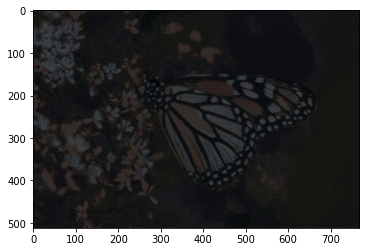

In [61]:
if __name__ == "__main__":
    # A = np.array(Image.open("img.jpg"))
    # A_prime = np.array(Image.open("img_.jpg"))
    # B = np.array(Image.open("img.jpg"))
    # B_prime = np.array(Image.open("img_.jpg"))
    A = cv2.imread("img/ours_10_aaa.jpg")[...,::-1]
    A_prime = cv2.imread("img/ours_10_aaa.jpg")[...,::-1]
    B = cv2.imread("img/face.jpg")[...,::-1]
    B_prime = cv2.imread("img/face.jpg")[...,::-1]
    patch_size = 5
    search_radius = 6
    itrs = 5
    nnf = init_nnf(A, B)
    start = time.time()
    nnf = NNF_Search(A, B, A_prime, B_prime, nnf, patch_size, itrs, search_radius)
    rec = warp(nnf, B)
    end = time.time()
    print(end - start)
    # Image.fromarray(np.uint8(rec)).show()
    # Image.fromarray(np.uint8(rec)).save("C://Users//gmt//Desktop//gmt.jpg")
    plt.imshow(np.uint8(rec))
    plt.imsave("test3.png", np.uint8(rec))

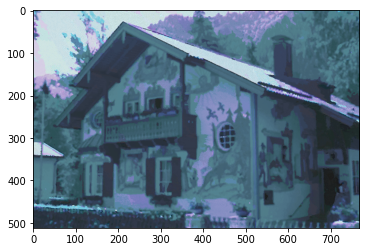

In [45]:
plt.imshow(np.uint8(rec))
plt.imsave("test.png", np.uint8(rec))

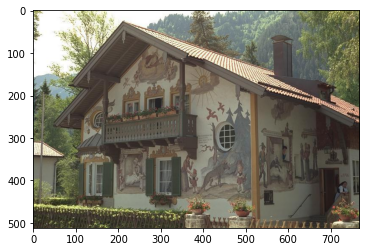

In [59]:
A = cv2.imread("img/ours_9_aaa.jpg")
A = A[...,::-1]
plt.imshow(A)

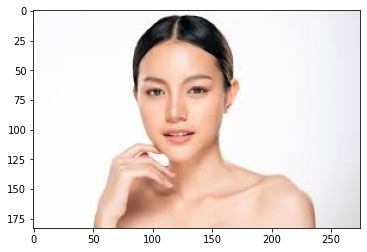

In [56]:
A = cv2.imread("img/face.jpg")
A = A[...,::-1]
plt.imshow(A)


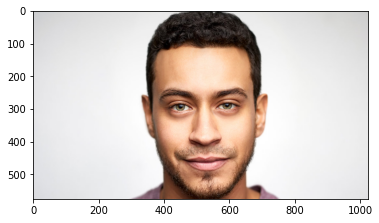

In [55]:
B = cv2.imread("img/face2.jpg")
B = B[...,::-1]
plt.imshow(B)